In [575]:
import os
import requests
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [576]:
# https://github.com/cvdfoundation/mnist?tab=readme-ov-file
DATA_DIR = "/app/dataset/MNIST"
os.makedirs(DATA_DIR, exist_ok=True)

In [577]:
import gzip
import shutil


def download_mnist():
    MNIST_FILES = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
    }
    for name, url in MNIST_FILES.items():
        out_path = os.path.join(DATA_DIR, url.split('/')[-1])
        result_path = out_path[:-3] 
        if not os.path.exists(result_path):
            if not os.path.exists(out_path):
                print(f"Downloading {name}...")
                r = requests.get(url)
                with open(out_path, 'wb') as f:
                    f.write(r.content)
            else:
                print(f"{name} already downloaded.")
            print(f"Unzipping {out_path}...")
            with gzip.open(out_path, 'rb') as f_in:
                with open(result_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        
        else:
            print(f"{name} already unzipped.")

In [578]:
download_mnist()

train_images already unzipped.
train_labels already unzipped.
test_images already unzipped.
test_labels already unzipped.


In [579]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    print(folder + "/" + prefix + '-images-idx3-ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "/app/dataset/MNIST" )
testImages, testLabels = loadMNIST( "t10k", "/app/dataset/MNIST" )

/app/dataset/MNIST/train-images-idx3-ubyte
/app/dataset/MNIST/t10k-images-idx3-ubyte


In [580]:
def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding


In [581]:
X_train = trainingImages / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = testImages / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)


y_train = toHotEncoding( trainingLabels )
y_test = toHotEncoding( testLabels )

print(f"{X_train.shape}:{y_train.shape}")

(60000, 784):(60000, 10)


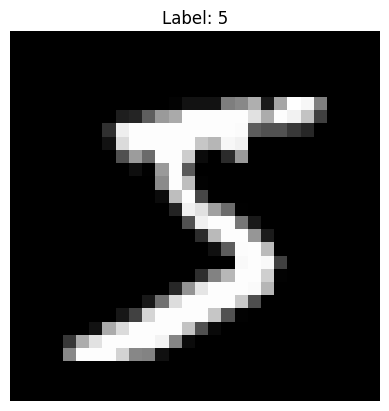

In [582]:
i = 0

image = trainingImages[i]  
label = trainingLabels[i]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [583]:

# https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they
# I wanna be able to stack layers
# idea is if tthis get passed to antoher then it will build the neural net
# build weight matrix
# get frontprop calc to work
def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh(x):
    return np.tanh(x)

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def binary_cross_entropy_derivative(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, lambda x: (x > 0).astype(float)),
    'tanh': (tanh, lambda x: 1 - np.tanh(x)**2),
    None: (lambda x: x, lambda x: 1)  # No activation
}

class LinearLayer():
    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # self.W=np.random.randint(10, size=(outFeature, inFeature)).astype(np.float64)
        self.W = np.random.randn(outFeature, inFeature) * 0.01  # small Gaussian
        self.b = np.zeros((1, inFeature), dtype=np.float64)
        self.trainable=True
        self.activation_name = activationFunction
        self.activation, self.activation_deriv = activation_map.get(
            self.activation_name, (lambda x: x, lambda x: 1)
        )
        self.dEdx=0
        self.dEdy=0
        self.y=0
        # print(self.W)
    def Forward(self, X):
        self.X = X 
        # print(f"{X.shape}:{self.W.shape}")
        output=X@self.W+self.b
       
        output = self.activation(output)
        # print(output)
        self.y=output
        return self.y
    def Backward(self, y, lr=0.01):
        self.dEdy=self.y-y
        dydx=self.activation_deriv(self.y)
        self.dEdx= dydx*self.dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)

        self.W-=lr*dEdW
        self.b-=lr*dEdb
        return self.dEdx @ self.W.T   
    def BackwardHidden(self, dEdy, lr=0.01):
        # honestly, dont hardcode it like this, but I got no choice
        dydx=self.activation_deriv(self.y)
        self.dEdx= dydx*dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)

        self.W-=lr*dEdW
        self.b-=lr*dEdb
        return self.dEdx @ self.W.T 
    def Reset():
        pass
    def Build():
        # we want to just cache the derivative of the function
        pass



class Model():
    def __init__(self, layers) -> None:
        self.layers=layers
    def ForwardProp(self, X):
        for i in range(len(self.layers)):
            X=self.layers[i].Forward(X)
        return X
    def BackwardProp(self, y, learningRate=0.01):
        print("running backprop")
        for i, layer in enumerate(self.layers[::-1]):
            if i == 0:
                dEdx = layer.Backward(y, lr=learningRate)
            else:
                dEdx = layer.BackwardHidden(dEdx, lr=learningRate)

    

In [584]:
layerSequence = [
    LinearLayer(inFeature=128, outFeature=784, activationFunction="sigmoid"),
    LinearLayer(inFeature=64, outFeature=128, activationFunction="sigmoid"),
    LinearLayer(inFeature=10, outFeature=64)  # final logits (softmax applied outside)
]
model=Model(layerSequence)

In [585]:
i = 3
image = trainingImages[i].reshape(1, -1) / 255.0  
label = trainingLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)

predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")

True label: 1, Predicted label: 4


In [ ]:
epochs = 10
learning_rate = 0.01
losses = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    
    # Forward pass
    y_logits = model.ForwardProp(X_train)
    print(X_train.shape)
    y_pred = softmax(y_logits)  # Apply softmax to get probabilities

    # Compute categorical cross-entropy loss
    loss = categorical_cross_entropy(y_pred, y_train)
    losses.append(loss)
    
    # Backward pass and update weights
    model.BackwardProp(y_train, learning_rate)

    print(f"Loss: {loss:.4f}")

Epoch 1
(784,)
running backprop


/tmp/ipykernel_1092743/996587337.py:17: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x))
/tmp/ipykernel_1092743/996587337.py:17: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 60000 is different from 1)

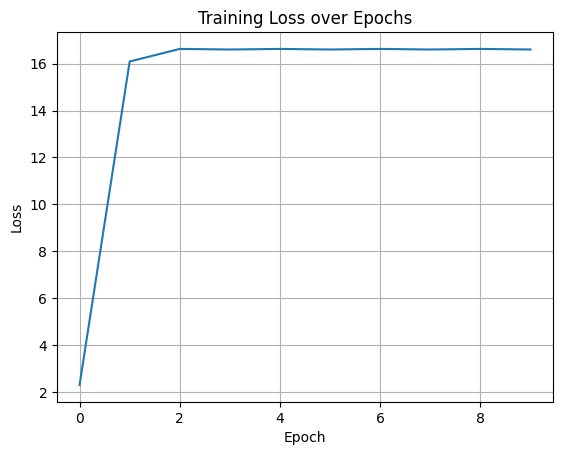

In [587]:
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()